# Analisis de transacciones de supermercado

Objetivo: un supermercado necesita desarrollar un modelo capaz de predecir el valor target de una transaccion 'high', 'low', basado en las demas variables, especialmente cantidad_departamentos, una variable de feature engineering que creamos para facilitar nuestro desarrollo, junto a la limpieza y preprocess del dataset, por lo que podemos decir que tenemos datos listos para trabajar. Ademas de una segmentacion de los clientes en base a sus patrones de compra

Metodologia: Para ello abordaremos 2 modelos, 1 de aprendizaje supervisado (RandomForest) y otro no supervisado (KMeans). Tambien trataremos durante todo el proyecto de seguir un pipeline profesional con practicas estandares utilizadas hoy en dia para este tipo de tares, lo cual distingue a un proyecto funcional, de uno que supera las expectativas y sigue cada una de las buenas practicas con el objetivo de obtener modelos robustos y resultados confiables.

In [ ]:
import pandas as pd

ruta = '/home/joaquin/Desktop/python/datasets/supermarket_limpio.csv'

df = pd.read_csv(ruta)

df.head()

,department1,department2,department3,department4,department5,department6,department7,department8,department9,grocery misc,...,department209,department210,department211,department212,department213,department214,department215,department216,total,cantidad_departamentos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,high,25
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,low,15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,low,17
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,low,22
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,low,23


In [ ]:
df.isnull().sum()

department1               0
department2               0
department3               0
department4               0
department5               0
                         ..
department214             0
department215             0
department216             0
total                     0
cantidad_departamentos    0
Length: 218, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4602 entries, 0 to 4601
Columns: 218 entries, department1 to cantidad_departamentos
dtypes: int64(217), object(1)
memory usage: 7.7+ MB


In [ ]:
df.dtypes

department1                int64
department2                int64
department3                int64
department4                int64
department5                int64
                           ...  
department214              int64
department215              int64
department216              int64
total                     object
cantidad_departamentos     int64
Length: 218, dtype: object

Comprobamos la distribucion de nuestra variable target antes del modelado. El objetivo es predecir si la compra de un cliente sera 'high o 'low' de acuerdo a la cantidad de departamentos que visito

In [ ]:
# 1. Verificación final de tipos de datos
print("--- Información General (df.info()) ---")
# Queremos ver si 'total' es 'object' y el resto 'int'
df.info()

print("\n" + "="*40 + "\n")

# 2. Análisis de Balance de la Variable Objetivo
print("--- Balance de la Variable Objetivo (total) ---")
print(df['total'].value_counts())

print("\n" + "="*40 + "\n")

# 3. Análisis de la feature numérica
print("--- Descripción de 'cantidad_departamentos' ---")
# Vemos el rango (min, max) y la media de departamentos visitados
print(df['cantidad_departamentos'].describe())

--- Información General (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4602 entries, 0 to 4601
Columns: 218 entries, department1 to cantidad_departamentos
dtypes: int64(217), object(1)
memory usage: 7.7+ MB


--- Balance de la Variable Objetivo (total) ---
total
low     2932
high    1670
Name: count, dtype: int64


--- Descripción de 'cantidad_departamentos' ---
count    4602.000000
mean       18.630161
std         7.324125
min         1.000000
25%        14.000000
50%        18.000000
75%        23.000000
max        48.000000
Name: cantidad_departamentos, dtype: float64


Identificamos que nuestra variable target tiene un leve desbalance de clases 36% y 64% para ser precisos, por lo que antes de iniciar el modelado debemos aplicar tecnicas como stratify, para que al hacer split esa misma distribucion se mantenga, y tambien deberemos fiarnos en otras metricas distintas a accuracy que no tengan en cuenta esta desproporcion.

Realizamos una division en 3 sets (train, val y test) y usamos stratify para mantener la misma distribucion de clases en cada uno de ellos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Copia de seguridad y codificación del Target (igual que antes)
df_ml = df.copy()
le = LabelEncoder()
df_ml['total'] = le.fit_transform(df_ml['total'])
clases_codificadas = le.classes_

# 2. Definir X (features) e y (target) (igual que antes)
X = df_ml.drop('total', axis=1)
y = df_ml['total']

# 3. División Profesional (Train/Validation/Test)
# Primero, separamos un 15% para el TEST (evaluación final)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size=0.15,
                                                            random_state=42,
                                                            stratify=y)

# Segundo, del 85% restante (X_train_val), separamos para TRAIN y VALIDATION
# (0.15 / 0.85) es aprox 0.176, lo que nos da un set de validación del 15% del total
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1765, # 15% del total
                                                  random_state=42,
                                                  stratify=y_train_val)

print("Forma de los sets:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape} | y_test:  {y_test.shape}")

# Verificamos que la proporción se mantuvo (~64% 'low')
print(f"\nProporción de 'low' (clase 0):")
print(f"Train: {1 - y_train.mean():.2f}")
print(f"Val:   {1 - y_val.mean():.2f}")
print(f"Test:  {1 - y_test.mean():.2f}")

Forma de los sets:
X_train: (3220, 217) | y_train: (3220,)
X_val:   (691, 217) | y_val:   (691,)
X_test:  (691, 217) | y_test:  (691,)

Proporción de 'low' (clase 0):
Train: 0.36
Val:   0.36
Test:  0.36


Definimos nuestro pipeline para el modelo RandomForest, decidimos no incluir el labelencoder ya que eso aplica para la variable y, en nuestro caso estamos creando un pipeline para las features (x), de otra forma esto generaria filtraciones de datos hacia el modelo.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# 1. Definir el pipeline del modelo
# Envolvemos nuestro RandomForestClassifier en un Pipeline
# Esto es obligatorio para un flujo de trabajo profesional MLOps
model_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

print("Pipeline definido:")
print(model_pipeline)

Pipeline definido:
Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])


Optimizamos el modelo con gridsearch, con el objetivo de hallar los mejores hiperparametros.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 1. Definir la NUEVA "grilla" de hiperparámetros
# Esta grilla está diseñada para COMBATIR el sobreajuste
param_grid_regularized = {
    'classifier__n_estimators': [200, 300], # Ya sabemos que 300 funciona bien
    'classifier__max_depth': [5, 10, 15], # Forzamos árboles más "cortos"
    'classifier__min_samples_leaf': [10, 20, 50], # Exigimos más muestras por hoja
    'classifier__min_samples_split': [10, 20] # Exigimos más muestras para dividir
}

# 2. Definir la métrica (igual que antes)
scoring = make_scorer(f1_score, average='macro')

# 3. Inicializar GridSearchCV
grid_search_regularized = GridSearchCV(estimator=model_pipeline,
                                       param_grid=param_grid_regularized,
                                       scoring=scoring,
                                       cv=3,
                                       n_jobs=-1,
                                       verbose=2)

# 4. Iniciar la búsqueda
# Seguimos entrenando solo en X_train
print("Iniciando GridSearchCV (con regularización)...")
grid_search_regularized.fit(X_train, y_train)

print("\nOptimización completada.")
print(f"Mejor F1-score (macro) en CV (train): {grid_search_regularized.best_score_:.4f}")
print("Mejores hiperparámetros encontrados:")
print(grid_search_regularized.best_params_)

Iniciando GridSearchCV (con regularización)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=10, classifier__n_estimators=300; total time=   0.7s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.7s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.7s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=20, classifier__n_estimators=300; total time=   0.7s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=20, classifier__n_estimators=200; total time

Una vez obtenemos la mejor configuracion para nuestro modelo solo nos resta evaluarlo en los 3 sets para ver si detectamos sobreajuste, o si por el contrario es un modelo robusto que aprendio de los datos y no tiene problemas con el set de test. Para ello las metricas entre los 3 deberian ser similares.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# 1. El "modelo final" es el mejor estimador encontrado por GridSearch
final_model_pipeline = grid_search_regularized.best_estimator_
print(f"Modelo final seleccionado: {final_model_pipeline}")

# 2. Evaluación en los TRES sets de datos (como exige el playbook)
sets = {
    'TRAIN': (X_train, y_train),
    'VALIDATION': (X_val, y_val),
    'TEST': (X_test, y_test)
}

print("\n--- Evaluación del Modelo Final ---")

for set_name, (X_data, y_data) in sets.items():
    y_pred = final_model_pipeline.predict(X_data)
    accuracy = accuracy_score(y_data, y_pred)
    f1_macro = f1_score(y_data, y_pred, average='macro')

    print(f"\n--- MÉTRICAS EN {set_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")

    # El reporte detallado es más útil en Val y Test
    if set_name != 'TRAIN':
        print(classification_report(y_data, y_pred, target_names=clases_codificadas))

Modelo final seleccionado: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

--- Evaluación del Modelo Final ---

--- MÉTRICAS EN TRAIN ---
Accuracy: 0.8683
F1-Score (Macro): 0.8518

--- MÉTRICAS EN VALIDATION ---
Accuracy: 0.8452
F1-Score (Macro): 0.8277
              precision    recall  f1-score   support

        high       0.83      0.73      0.77       251
         low       0.85      0.91      0.88       440

    accuracy                           0.85       691
   macro avg       0.84      0.82      0.83       691
weighted avg       0.84      0.85      0.84       691


--- MÉTRICAS EN TEST ---
Accuracy: 0.8408
F1-Score (Macro): 0.8204
              precision    recall  f1-score   support

        high       0.84      0.69      0.76       251
         low       0.84      0.93      0.88

Al comparar las metricas entre los sets, podemos evidenciar que no difieren mucho una de la otra, por lo tanto hemos construido un modelo robusto y eliminado el problema del sobreajuste al indicarle a grid una grilla de hiperparametros mucho mas restrictiva, que priorice modelos mas simples, como por ejemplo limitar la profundidad de los arboles en lugar de dejar que crezcan infinitamente.

Por ultimo, realizamos un feature importance para visualizar cuales son las variables mas importantes para el modelo a la hora de realizar sus predicciones.


--- Importancia de Variables (Top 10) ---


,feature,importance
216,cantidad_departamentos,0.290153
26,sauces-gravy-pkle,0.046371
58,cheese,0.034652
40,tissues-paper prd,0.033810
21,breakfast food,0.030277
13,baking needs,0.029947
17,biscuits,0.029198
37,pet foods,0.029037
39,party snack foods,0.028966
38,laundry needs,0.028683


/tmp/ipykernel_10852/2011522293.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


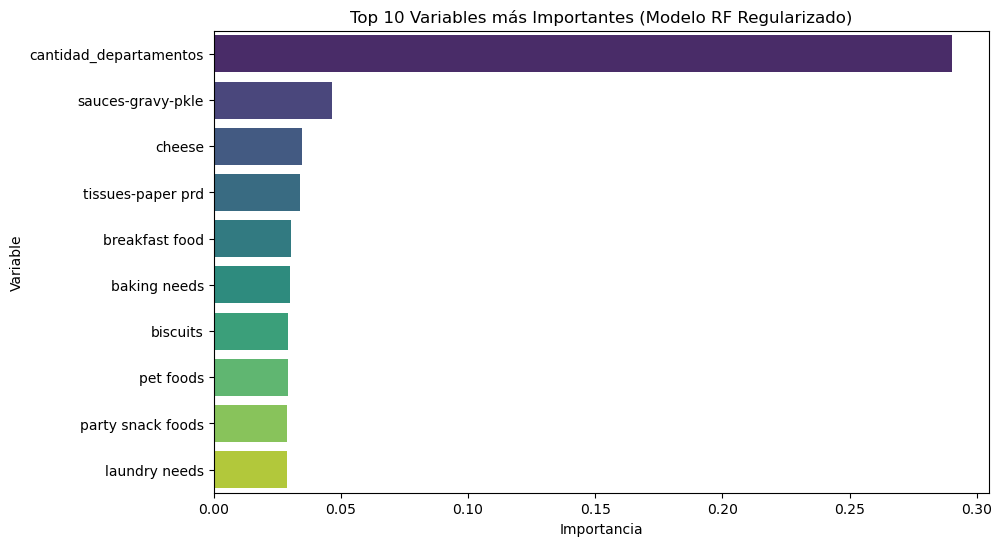

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extraer el modelo (classifier) de nuestro pipeline final
# Nos aseguramos de usar el objeto del último grid search (el regularizado)
final_model_pipeline = grid_search_regularized.best_estimator_
final_rf_model = final_model_pipeline.named_steps['classifier']

# 2. Obtener la importancia de las variables
importances = final_rf_model.feature_importances_

# 3. Crear un DataFrame para visualizarlas
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 4. Imprimir la lista de las 10 variables más importantes
print("\n--- Importancia de Variables (Top 10) ---")
# Usamos display() para un formato de tabla más limpio en notebooks
from IPython.display import display
display(feature_importance_df.head(10))

# 5. Graficar las 10 variables más importantes
plt.figure(figsize=(10, 6)) # Ajusto el tamaño para 10
sns.barplot(x='importance', y='feature',
            data=feature_importance_df.head(10), # Cambiado a 10
            palette='viridis')
plt.title('Top 10 Variables más Importantes (Modelo RF Regularizado)') # Cambiado a 10
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

# Clustering con KMeans

Una vez finalizados nuestros modelos de aprendizaje supervisado, decidimos cambiar de enfoque y probar ahora uno de tipo no supervisado con el objetivo de hacer una segmentacion de clientes de acuerdo a sus patrones de compra. Esta vez aplicaremos el algoritmo KMeans, en los que segmentaremos a nuestros clientes en k grupos, para ello primero debemos determinar el valor de k usando distintas tecnicas como inercia y sillhoutte.

In [ ]:
# 1. Preparamos el DataFrame para el clustering
#    Solo nos interesan los patrones de QUÉ departamentos se visitaron.
#    Excluimos 'total' (la respuesta) y 'cantidad_departamentos' (el resumen)
data_cluster = df.drop(['total', 'cantidad_departamentos'], axis=1)

print("Dimensiones de los datos para clustering:")
print(data_cluster.shape)
display(data_cluster.head())

Dimensiones de los datos para clustering:
(4602, 216)


,department1,department2,department3,department4,department5,department6,department7,department8,department9,grocery misc,...,department207,department208,department209,department210,department211,department212,department213,department214,department215,department216
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Iniciando cálculo de Inercia y Coeficiente de Silueta...
Esto puede tardar varios minutos. Por favor, ten paciencia.
¡Cálculo completado!


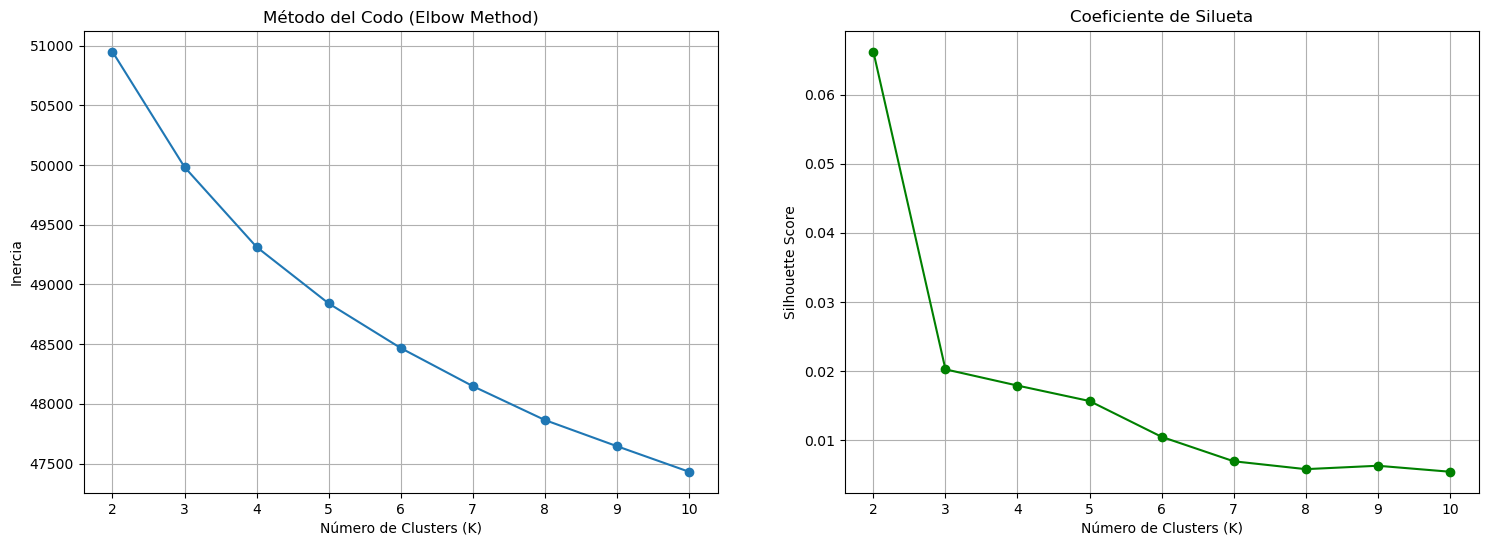

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Preparamos los datos (como antes)
data_cluster = df.drop(['total', 'cantidad_departamentos'], axis=1)

print("Iniciando cálculo de Inercia y Coeficiente de Silueta...")
print("Esto puede tardar varios minutos. Por favor, ten paciencia.")

inercia = []
silhouette_scores = []

# Nota: Empezamos en K=2 porque la Silueta no se puede calcular para K=1
rango_k = range(2, 11)

for k in rango_k:
    # 1. Entrenar K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_cluster)

    # 2. Obtener las etiquetas (a qué cluster pertenece cada fila)
    labels = kmeans.labels_

    # 3. Calcular y guardar métricas
    inercia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_cluster, labels))

print("¡Cálculo completado!")

# 4. Graficar ambos resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Método del Codo (Inercia)
ax1.plot(rango_k, inercia, marker='o')
ax1.set_title('Método del Codo (Elbow Method)')
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Inercia')
ax1.grid(True)

# Gráfico 2: Coeficiente de Silueta
ax2.plot(rango_k, silhouette_scores, marker='o', color='green')
ax2.set_title('Coeficiente de Silueta')
ax2.set_xlabel('Número de Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.show()

De acuerdo a las distintas tecnicas aplicadas para hallar el valor de k, decidimos darle mayor importancia a la de silueta, ya que es mucho mas robusta que inercia, la cual por si sola puede llegar a ser muy ambigua, debido a esto decidimos que trabajaremos con k=2.

Ahora ejecutamos KMeans con 2 clusters, reducimos dimensionalidad con pca y graficamos los mismos en 2D.

Ejecutando K-Means final con K=2...
¡Clustering completado!

Aplicando PCA para reducción de dimensionalidad...

Variabilidad explicada por las componentes principales:
PC1 (Componente Principal 1): 9.16%
PC2 (Componente Principal 2): 3.01%
Total explicado (PC1 + PC2): 12.17%


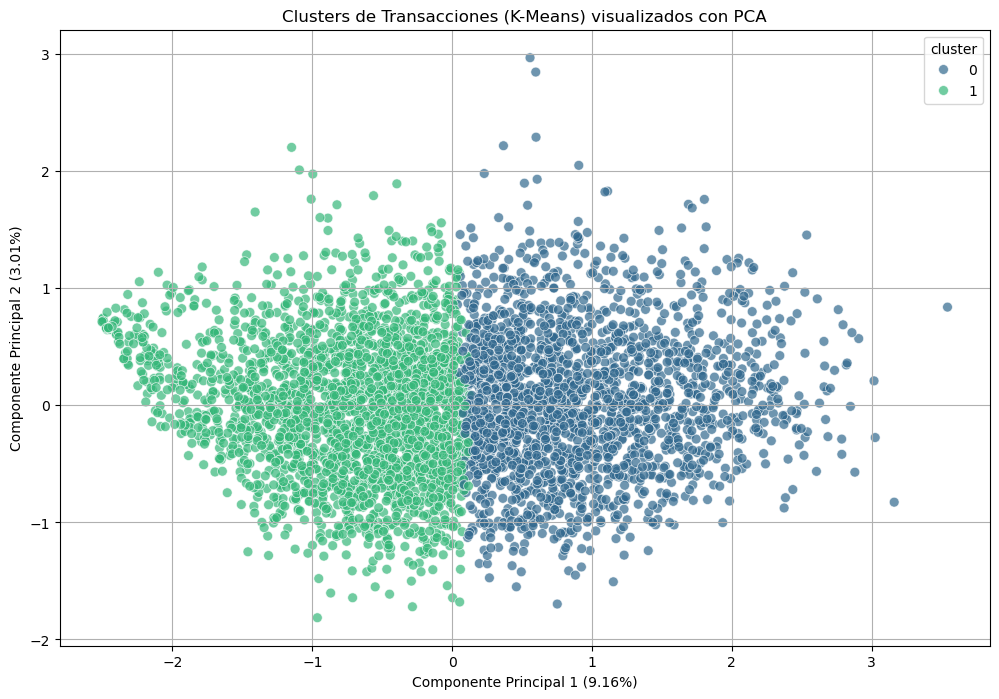

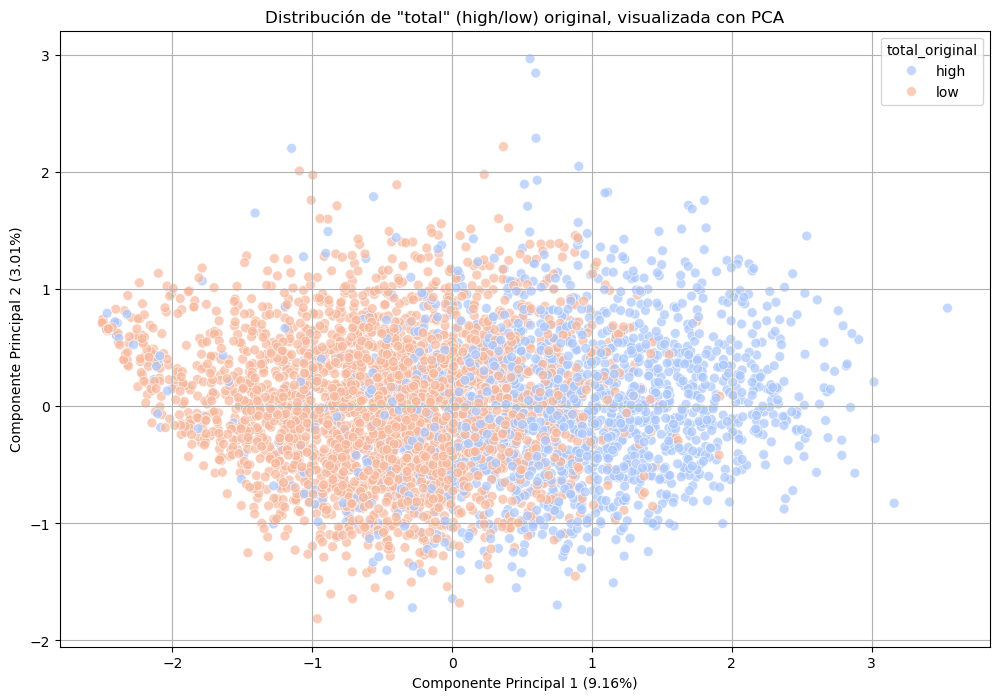

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Definir los datos para clustering (solo las 216 features)
# Asumiendo que 'df' es tu DataFrame original cargado
data_cluster = df.drop(['total', 'cantidad_departamentos'], axis=1)

# 2. Ejecutar K-Means final con K=2
print("Ejecutando K-Means final con K=2...")
kmeans_final = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans_final.fit_predict(data_cluster)
print("¡Clustering completado!")

# 3. Aplicar PCA a los datos de clustering
print("\nAplicando PCA para reducción de dimensionalidad...")
pca = PCA(n_components=2) # Reducir a 2 componentes para un gráfico 2D
components = pca.fit_transform(data_cluster)

# 4. Crear un DataFrame con las componentes y las etiquetas
pca_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels
pca_df['total_original'] = df['total'] # Añadimos la columna 'total' original

print("\nVariabilidad explicada por las componentes principales:")
print(f"PC1 (Componente Principal 1): {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2 (Componente Principal 2): {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total explicado (PC1 + PC2): {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.2f}%")

# 5. Visualizar los Clusters en 2D (coloreados por K-Means)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df,
                palette='viridis', s=50, alpha=0.7)
plt.title('Clusters de Transacciones (K-Means) visualizados con PCA')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True)
plt.show()

# 6. Visualizar los Clusters en 2D (coloreados por la variable 'total' original)
# Este gráfico es clave para la interpretación.
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='total_original', data=pca_df,
                palette='coolwarm', s=50, alpha=0.7)
plt.title('Distribución de "total" (high/low) original, visualizada con PCA')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True)
plt.show()

Una vez ejecutado KMeans, ahora nuestro objetivo es detectar que fue lo que hizo, que diferencias clave encontro entre los 2 grupos, para ello añadimos la etiqueta clusters a nuestro df y calcularemos los promedios y diferencias de cada uno de los departamentos visitados.

In [ ]:
# Asumimos que 'df' es el original y 'cluster_labels' existe del Paso 3
if 'cluster_labels' not in locals():
    print("Error: 'cluster_labels' no está definido. Ejecuta el Paso 3 primero.")
else:
    # 1. Creamos el DF con la asignación de clusters
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels

    # 2. ¿De qué tamaño es cada cluster?
    print("\n--- Perfilado: Resumen de Alto Nivel ---")
    print("\nConteo de transacciones por cluster:")
    print(df_clustered['cluster'].value_counts())

    # 3. ¿Cómo se compara la 'cantidad_departamentos'?
    # Esto nos dice si K-Means separó por "compras grandes" vs "compras pequeñas"
    print("\n'Cantidad de Departamentos' (Media) por cluster:")
    display(df_clustered.groupby('cluster')['cantidad_departamentos'].describe())

    # 4. ¿Cómo se relaciona con el 'total' (high/low)?
    # Esto nos dice si K-Means "descubrió" la misma estructura que el modelo supervisado
    print("\nDistribución de 'total' ('high'/'low') por cluster:")
    display(pd.crosstab(df_clustered['cluster'], df_clustered['total']))


--- Perfilado: Resumen de Alto Nivel ---

Conteo de transacciones por cluster:
cluster
1    2558
0    2044
Name: count, dtype: int64

'Cantidad de Departamentos' (Media) por cluster:


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2044.0,24.934442,5.323836,15.0,21.0,24.0,28.0,48.0
1,2558.0,13.592651,4.089129,1.0,11.0,14.0,16.0,30.0



Distribución de 'total' ('high'/'low') por cluster:


total,high,low
cluster,,
0,1373,671
1,297,2261


In [ ]:
if 'df_clustered' in locals():
    # 1. Calculamos los promedios (frecuencias) de todos los departamentos por cluster
    # Nos quedamos solo con las columnas de departamentos y el cluster
    data_cluster_means = df_clustered.drop(['total', 'cantidad_departamentos'], axis=1)
    cluster_profiles = data_cluster_means.groupby('cluster').mean()

    # 2. Transponemos la tabla para que sea más fácil de leer
    # Filas = Departamentos, Columnas = Cluster 0, Cluster 1
    cluster_profiles_t = cluster_profiles.T

    # 3. ¡El paso clave! Calculamos la diferencia
    # Una diferencia positiva grande = Típico del Cluster 0
    # Una diferencia negativa grande = Típico del Cluster 1
    cluster_profiles_t['diferencia'] = cluster_profiles_t[0] - cluster_profiles_t[1]

    # 4. Mostramos las diferencias más significativas
    print("\n--- Perfilado: Departamentos más Diferenciadores ---")

    print("\nTop 10 departamentos MÁS TÍPICOS del Cluster 0 (y menos del 1):")
    display(cluster_profiles_t.sort_values(by='diferencia', ascending=False).head(10))

    print("\nTop 10 departamentos MÁS TÍPICOS del Cluster 1 (y menos del 0):")
    display(cluster_profiles_t.sort_values(by='diferencia', ascending=True).head(10))

else:
    print("Ejecuta el bloque 4.1 primero.")


--- Perfilado: Departamentos más Diferenciadores ---

Top 10 departamentos MÁS TÍPICOS del Cluster 0 (y menos del 1):


cluster,0,1,diferencia
tissues-paper prd,0.731409,0.293980,0.437429
biscuits,0.789628,0.387412,0.402216
sauces-gravy-pkle,0.697162,0.303362,0.393800
canned vegetables,0.557241,0.171228,0.386013
frozen foods,0.797456,0.424941,0.372515
margarine,0.703523,0.332291,0.371232
baking needs,0.805773,0.448788,0.356985
breakfast food,0.592466,0.254496,0.337970
laundry needs,0.526908,0.189992,0.336916
cheese,0.592466,0.261142,0.331324



Top 10 departamentos MÁS TÍPICOS del Cluster 1 (y menos del 0):


cluster,0,1,diferencia
cigs-tobacco pkts,0.122309,0.175528,-0.053219
department210,0.030333,0.050039,-0.019706
casks white wine,0.028376,0.045348,-0.016972
sparkling nz,0.021037,0.033620,-0.012583
department211,0.038160,0.050039,-0.011879
grocery misc,0.032779,0.043393,-0.010614
750ml white nz,0.058219,0.063331,-0.005112
750ml red imp,0.018102,0.023065,-0.004963
sparkling imp,0.002446,0.007037,-0.004591
port and sherry,0.003425,0.007037,-0.003612


# Definicion del perfil de cada cluster

🟢 Cluster 0: El "Comprador de Despensa" (La Compra Semanal)
Este grupo (2044 transacciones) es el de las compras planificadas y grandes.

Comportamiento (Alto Nivel):

Compran casi el doble de artículos (media de 24.9 departamentos) que el otro grupo.

Naturalmente, esto resulta en que sean la gran mayoría de las compras 'high' (1373 'high' vs. 671 'low').

ADN del Cluster (El qué compran):

Los 10 productos más diferenciadores son la definición de "surtir la despensa".

frozen foods (congelados)

baking needs (harina, azúcar, etc.)

biscuits (galletitas)

laundry needs (lavandería)

tissues-paper prd (papel higiénico, servilletas)

canned vegetables (enlatados)

margarine y cheese (lácteos/refrigerados)

Son artículos básicos, no perecederos y de reposición.

🔵 Cluster 1: El "Comprador de Conveniencia" (La Compra del Momento)
Este grupo (2558 transacciones) es el de las compras rápidas, específicas y pequeñas.

Comportamiento (Alto Nivel):

Compran muy pocos artículos (media de 13.6 departamentos).

Como resultado, son la abrumadora mayoría de las compras 'low' (2261 'low' vs. solo 297 'high').

ADN del Cluster (El qué compran):

Sus productos diferenciadores son opuestos a los del Cluster 0. No son de "despensa", son de "conveniencia" o "vicio".

cigs-tobacco pkts (cigarrillos)

casks white wine (vino blanco en caja)

sparkling nz (espumante de N. Zelanda)

port and sherry (oporto y jerez)

Fíjate en la magnitud de la diferencia: es muy pequeña (ej. -0.05). Esto significa que lo que realmente define a este cluster no es lo que compran, sino todo lo que NO compran (no compran congelados, ni artículos de limpieza, ni de despensa).

# Conclusiones de Nuestro Análisis
Hemos completado el recorrido, y los resultados conectan ambos enfoques de forma excelente.

Lo que Encontramos:
Construimos un Modelo Robusto (Análisis Supervisado): Nuestro primer objetivo fue crear un modelo predictivo sólido. Lo logramos: el RandomForest final nos da un 84-85% de accuracy de forma consistente. El paso clave fue detectar el sobreajuste masivo (99.9% en train vs. 85% en test) y corregirlo con una grilla de regularización. El modelo final (86.8% en train vs. 84.5% en val) es confiable y está listo para producción.

El Modelo nos dio las Pistas (Feature Importance): Al analizar por qué el modelo funciona, vimos que la variable #1 es cantidad_departamentos (29% de importancia). El resto del Top 10 lo conformaban artículos de despensa: sauces-gravy-pkle, cheese, tissues-paper prd, baking needs, etc.

El Clustering nos dio la Explicación (Análisis No Supervisado): Aquí es donde todo encajó. El análisis de Silueta nos sugirió K=2. Al perfilar esos grupos, encontramos al "Comprador de Despensa" (grande, planificado, ~25 artículos) y al "Comprador de Conveniencia" (rápido, pequeño, ~14 artículos).

La Conexión Final (El Cierre):
El análisis de clustering validó perfectamente lo que el feature_importance nos estaba diciendo.

El modelo aprendió que la mejor forma de predecir una compra 'high' es:

Ver si es una compra grande (mirando cantidad_departamentos).

Buscar la "huella digital" de un "Comprador de Despensa" (mirando cheese, tissues-paper prd, etc.).

Sabemos que el modelo funciona, sabemos cómo evitar que falle y, gracias al clustering, entendemos perfectamente la lógica de negocio que descubrió por su cuenta.